<a href="https://colab.research.google.com/github/Bbonobono/Medicine/blob/main/pills_color_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import sklearn
from sklearn.cluster import KMeans
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
from PIL import Image
import cv2


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [230]:
path = '/content/drive/MyDrive/pills_train_no_bg/'
train_img = list()
cnt = 0
for i in range(100):
  im = Image.open(path+'{}.jpg'.format(cnt))
  img = np.array(im.resize((227,227)),dtype=np.float)

  train_img.append(img)
  cnt += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Clustering

In [180]:
def clustering(img, number_of_colors = 5):
  image = img
  number_of_colors = number_of_colors
  modified_image = image.reshape(image.shape[0]*image.shape[1], 3)
  clf = KMeans(n_clusters = number_of_colors)
  labels = clf.fit_predict(modified_image)

  counts = Counter(labels)
  center_colors = clf.cluster_centers_
  # We get ordered colors by iterating through the keys
  ordered_colors = [center_colors[i] for i in counts.keys()]
  hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
  rgb_colors = [ordered_colors[i] for i in counts.keys()]

  for i in range(len(hex_colors)):
      try:
          # 검은색 걸러내기
          # if hex_colors[i] == '#000000':
          #     del counts[i]
          #     del hex_colors[i]
          #     del rgb_colors[i]

          # 어두운 회색 걸러내기 --- 어디까지 기준으로 잡고 쳐내야 하나?
          if rgb_colors[i][0] < 140 and rgb_colors[i][1] < 140 and rgb_colors[i][2] < 140:
              del counts[i]
              del hex_colors[i]
              del rgb_colors[i]
      except:
          pass

  return rgb_colors, hex_colors, counts

In [231]:
result = clustering(train_img[0], number_of_colors=4)

Clustering 한 결과 가지고 파이차트 그리기

([<matplotlib.patches.Wedge at 0x7fab155f4390>,
 [Text(1.0470649700392733, 0.3371274959368574, '#5e8167'),
  Text(-1.0470649384751147, -0.3371275939701532, '#70c983')])

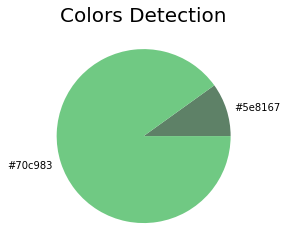

In [232]:
plt.title('Colors Detection', fontsize=20)
plt.pie(result[2].values(), labels = result[1], colors = result[1])

Classifying

In [233]:
def classify(rgb_tuple):

    
# 약학정보원 홈페이지 캡처 기준
    colors = {"하양": (255,255,255),
              "노랑" : (251,234,73),
              "주황" : (245,155,34),
              "분홍" : (245,111,213),
              "빨강" : (242,44,27),
              "갈색" : (163,75,41),
              "연두" : (144,193,79),
              "초록" : (47,148,51),
              "파랑" : (82,108,253),
              "남색" : (34,44,171),
              "자주" : (176,32,118),
              "보라" : (149,31,180),
              "회색" : (158,158,158),
#              "검정" : (0,0,0)
              }


# #국가기술표준원 표준색 기준
#     colors = {"하양": (243,244,242),
#               "노랑" : (255,209,13),
#               "주황" : (242,119,61),
#               "분홍" : (233,158,168),
#               "빨강" : (187,70,66),
#               "갈색" : (151,90,62),
#               "연두" : (148,192,86),
#               "초록" : (36,124,77),
#               "파랑" : (15,124,168),
#               "남색" : (65,74,103),
#               "자주" : (139,66,95),
#               "보라" : (102,85,129),
#               "회색" : (129,131,131),
#               "검정" : (0,0,0)
#               }


    manhattan = lambda x,y : abs(x[0] - y[0]) + abs(x[1] - y[1]) + abs(x[2] - y[2]) 
    distances = {k: manhattan(v, rgb_tuple) for k, v in colors.items()}
    color = min(distances, key=distances.get)
    return color

In [234]:
pillColor = list()
for _ in range(len(result[0])):
    pointColor = classify(result[0][_])
    pillColor.append(pointColor)
pillColor

['초록', '연두']

Clustering - Classifying N번 반복

In [235]:
resultList = list()
result = list()
pillColor = list()
for i in range(30):
  result = clustering(train_img[i], number_of_colors=4)
  for _ in range(len(result[0])):
    pointColor = classify(result[0][_])
    pillColor.append(pointColor)
  resultList.append([i,pillColor])
  pillColor = list()

In [205]:
result[0][0]

array([236.43710692, 168.56918239, 154.360587  ])

In [237]:
resultList

[[0, ['초록', '연두']],
 [1, ['노랑', '초록']],
 [2, ['회색', '하양']],
 [3, ['하양', '회색']],
 [4, ['자주', '회색']],
 [5, ['하양', '하양']],
 [6, ['회색', '주황']],
 [7, ['하양', '회색']],
 [8, ['회색', '하양']],
 [9, ['회색', '회색']],
 [10, ['갈색', '회색']],
 [11, ['회색', '하양']],
 [12, ['회색', '하양']],
 [13, ['회색', '회색']],
 [14, ['회색', '하양']],
 [15, ['회색', '주황']],
 [16, ['회색', '하양']],
 [17, ['주황', '노랑']],
 [18, ['회색', '하양']],
 [19, ['분홍', '회색']],
 [20, ['회색', '하양']],
 [21, ['연두', '회색']],
 [22, ['연두', '회색']],
 [23, ['회색', '분홍']],
 [24, ['회색', '초록']],
 [25, ['주황', '노랑']],
 [26, ['빨강', '주황']],
 [27, ['분홍', '하양']],
 [28, ['회색', '하양']],
 [29, ['초록', '초록']]]